# pretrained Nbeats model using all seasonality data - simulation data
---

     m4데이터의 모든 계절성분 데이터를 기학습모델에 학습시켜 전이학습을 통해 target data를 예측하는 nbeats-lstm 모델이다. 비교 모델로 target데이터를 적합할 단순 lstm과 nbeat 모델이 있으며,각 3개의 모델은 50번의 반복 시행과 예측으로 mse의 분포 히스토그램을 파악하여 pretrained model이 다른 모델에 비해 성능적 우위가 있는지를 파악하려고 한다.
   

In [21]:
# pretrain에 이용할 도메인 데이터 전처리는 사전 모듈에 저장
#from m4databasis import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y # 도메인 데이터
from target_data_electronic import * # 타겟데이터
#from simul_data_1111 import simul_X_train,simul_y_train,simul_low_X_test,simul_low_y_test,simul_many_X_test,simul_many_y_test
from pretrain_data_simul2 import sclae_X_train,sclae_y_train
from simul_data_1111_minmax_final import simul_X_train,simul_y_train,simul_low_X_test,simul_low_y_test,simul_many_X_test,simul_many_y_test

#from korea_solor import test_solor_X,test_solor_y,train_solor_X,train_solor_y

- pretrained data와 target data의 사전 처리는 모듈화하여 import시킴

In [22]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time

---
# data shape

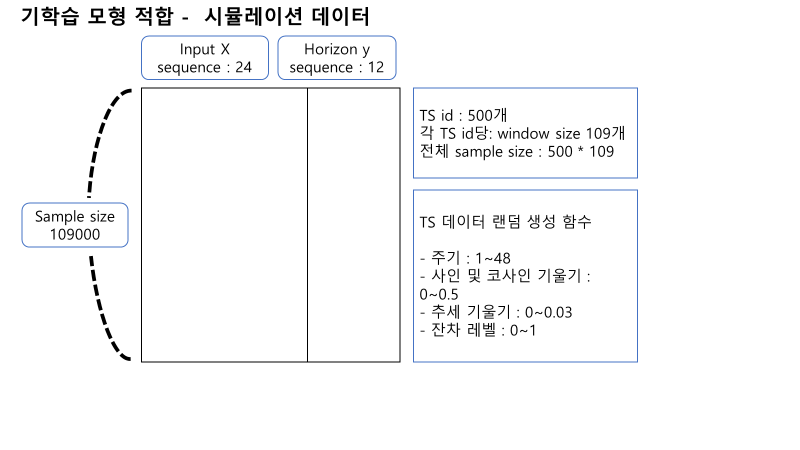

---
# pretrained model

- m4데이터 모든 계절성분 데이터를 적합
- 각 계절성분마다 각각 horizon과 inputsize가 다르다
- 다른 계절성 데이터 적합시 input과 output 차원이 바뀌어 적합

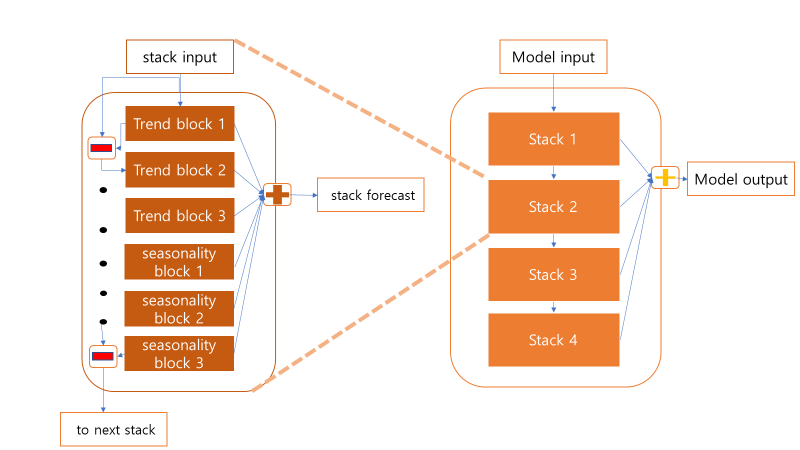

In [3]:
X_train.shape,y_train.shape,target_ele_X_test.shape,target_ele_y_test.shape

((109000, 24), (109000, 12), (1, 24), (1, 12))

In [25]:
K.clear_session()

input_dim, output_dim =  1, 1
backcast_, forecast_ = 24,12

model= NBeatsKeras( backcast_length=backcast_, forecast_length=forecast_, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(sclae_X_train,sclae_y_train,validation_data=(target_ele_X_test,target_ele_y_test),
                    epochs=50, batch_size=128,
                    callbacks=[early_stop])


Epoch 1/50
852/852 [==============================] - 63s 69ms/step - loss: 0.0091 - val_loss: 0.1143
Epoch 2/50
852/852 [==============================] - 57s 67ms/step - loss: 8.5748e-04 - val_loss: 0.1157
Epoch 3/50
852/852 [==============================] - 57s 67ms/step - loss: 8.2525e-04 - val_loss: 0.0896
Epoch 4/50
852/852 [==============================] - 57s 67ms/step - loss: 8.0456e-04 - val_loss: 0.0945
Epoch 5/50
852/852 [==============================] - 57s 67ms/step - loss: 7.9399e-04 - val_loss: 0.0921
Epoch 6/50
852/852 [==============================] - 57s 67ms/step - loss: 7.7994e-04 - val_loss: 0.0797
Epoch 7/50
852/852 [==============================] - 58s 68ms/step - loss: 7.7281e-04 - val_loss: 0.0777
Epoch 8/50
852/852 [==============================] - 58s 68ms/step - loss: 7.6513e-04 - val_loss: 0.0788
Epoch 9/50
852/852 [==============================] - 58s 68ms/step - loss: 7.6142e-04 - val_loss: 0.0790
Epoch 10/50
852/852 [=============================

KeyboardInterrupt: 

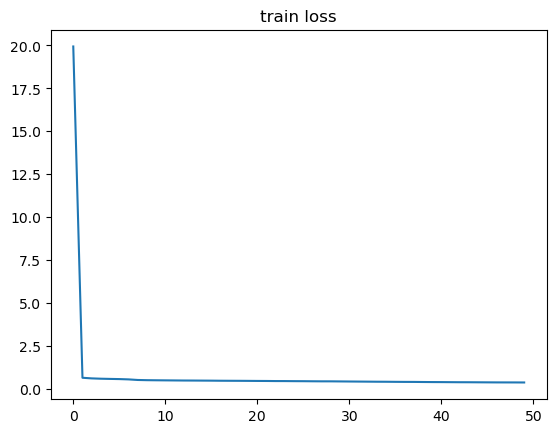

In [7]:
#history_nbeats = np.array([history_lst[i].history['loss'] for i in range(len(history_lst))]).flatten()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('train loss')
plt.show()

---
# pretrained nbeats-lstm

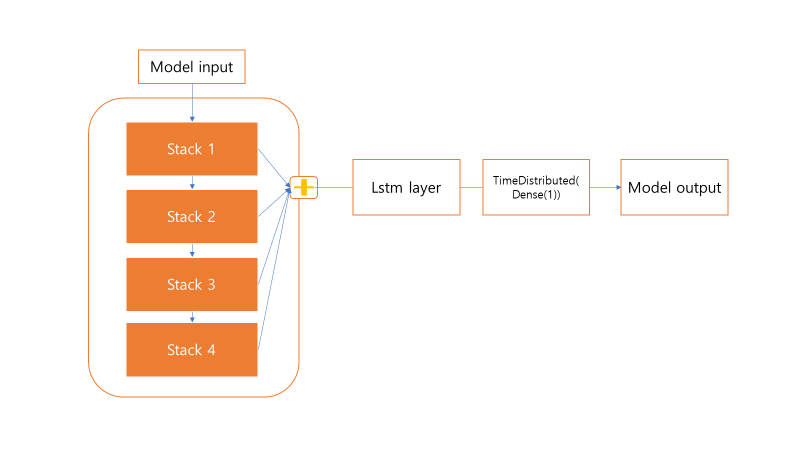

---
# 사전학습모델 반복 fitting

In [8]:
from keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed

In [26]:
backcast_length = 24
theta_dim1, theta_dim2 = 64,6
forecast_length = 12
unit=128

## simulation1
- $cos(\frac{2\pi t_i}{12})+sin(\frac{2\pi t_i}{3})+ 0.05t_i + \epsilon_i$

1/1 [==============================] - 0s 284ms/step


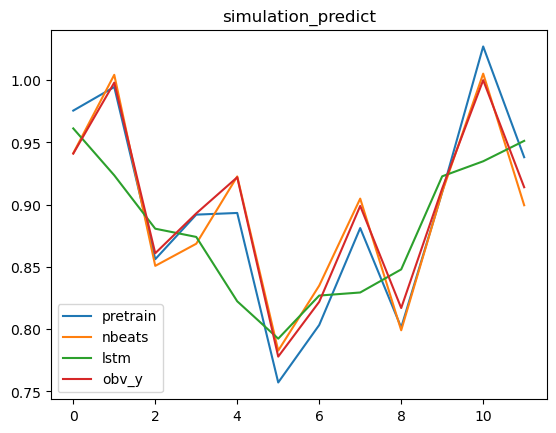

pretrain : 0.00039250217619868144 
nbeat : 0.0001272262335857671 
lstm  : 0.00236410317853731


In [27]:
X_train1 = np.array(simul_X_train[0])
y_train1 = np.array(simul_y_train[0])
X_test1 = simul_many_X_test[0].reshape(1,-1)
y_test1 = simul_many_y_test[0].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation2
- $cos(\frac{2\pi t_i}{12})+sin(2\pi t_i)+ 0.05t_i + \epsilon_i$

1/1 [==============================] - 0s 280ms/step


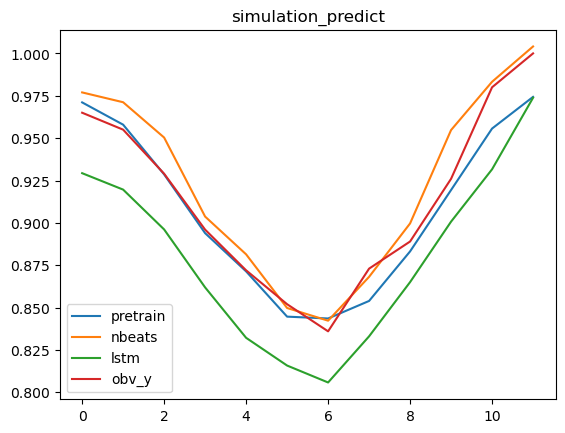

pretrain : 0.0001545543413403208 
nbeat : 0.00017054819750922986 
lstm  : 0.0012008550715952974


In [28]:
X_train1 = np.array(simul_X_train[1])
y_train1 = np.array(simul_y_train[1])
X_test1 = simul_many_X_test[1].reshape(1,-1)
y_test1 = simul_many_y_test[1].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation3
- $cos(\frac{2\pi t_i}{12})+sin(\frac{2\pi t_i}{3}) + \epsilon_i$

1/1 [==============================] - 1s 1s/step
Epoch 28: early stopping
1/1 [==============================] - 0s 285ms/step


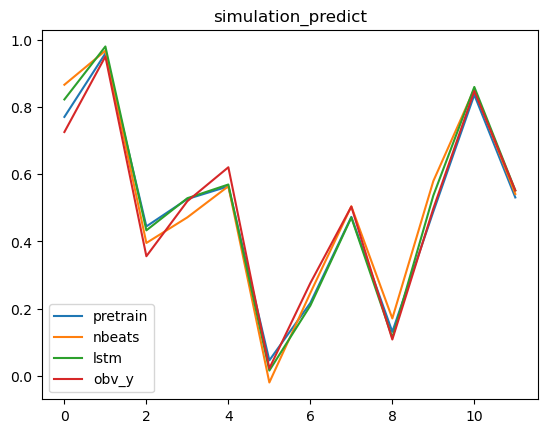

pretrain : 0.0016229193663928835 
nbeat : 0.0033847496224542212 
lstm  : 0.002187162191077648


In [29]:
X_train1 = np.array(simul_X_train[2])
y_train1 = np.array(simul_y_train[2])
X_test1 = simul_many_X_test[2].reshape(1,-1)
y_test1 = simul_many_y_test[2].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation4
- $cos(\frac{2\pi t_i}{12})+sin(2\pi t_i) + \epsilon_i$

1/1 [==============================] - 1s 1s/step
Epoch 26: early stopping
1/1 [==============================] - 0s 271ms/step


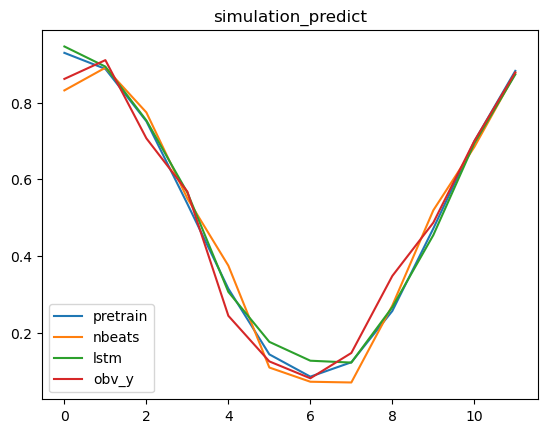

pretrain : 0.0018916226087463042 
nbeat : 0.0030671214533008902 
lstm  : 0.0022180129013671377


In [35]:
X_train1 = np.array(simul_X_train[3])
y_train1 = np.array(simul_y_train[3])
X_test1 = simul_many_X_test[3].reshape(1,-1)
y_test1 = simul_many_y_test[3].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation5
- $cos(\frac{2\pi t_i}{50})+sin(\frac{2\pi t_i}{25})+ 0.05t_i + \epsilon_i$

1/1 [==============================] - 0s 283ms/step


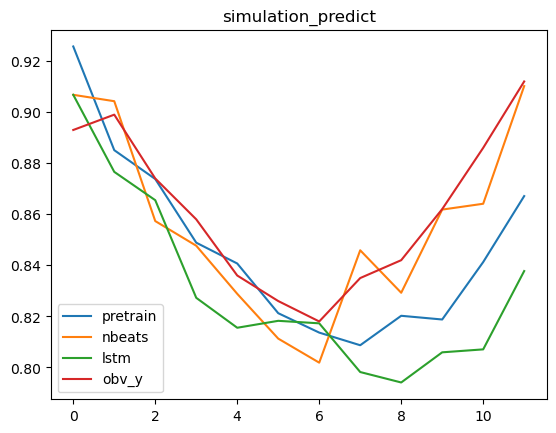

pretrain : 0.0007052388834734294 
nbeat : 0.0001578827932851651 
lstm  : 0.0017272692746896606


In [36]:
X_train1 = np.array(simul_X_train[4])
y_train1 = np.array(simul_y_train[4])
X_test1 = simul_low_X_test[0].reshape(1,-1)
y_test1 = simul_low_y_test[0].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation6
- $cos(\frac{2\pi t_i}{50})+sin(2\pi t_i) + 0.05t_i + \epsilon_i$

1/1 [==============================] - 1s 1s/step
Epoch 14: early stopping
1/1 [==============================] - 0s 283ms/step


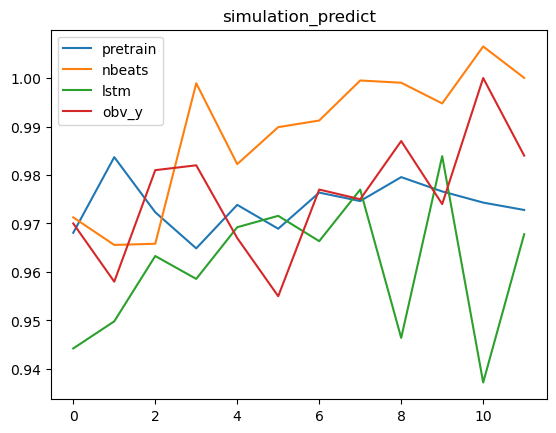

pretrain : 0.00017672115786862585 
nbeat : 0.00030843138101876294 
lstm  : 0.0006617561850824062


In [32]:
X_train1 = np.array(simul_X_train[5])
y_train1 = np.array(simul_y_train[5])
X_test1 = simul_low_X_test[1].reshape(1,-1)
y_test1 = simul_low_y_test[1].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation7
- $cos(\frac{2\pi t_i}{50})+sin(\frac{2\pi t_i}{25}) + \epsilon_i$

1/1 [==============================] - 0s 286ms/step


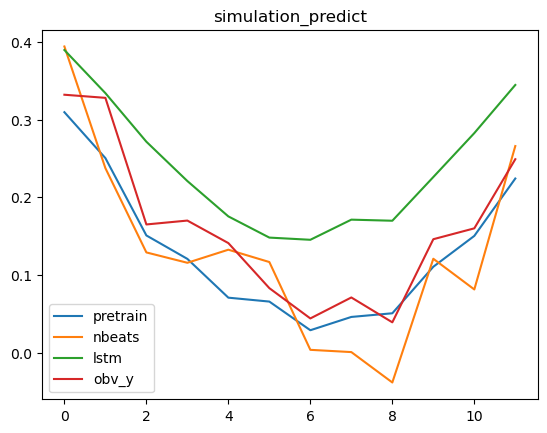

pretrain : 0.0014460136355070195 
nbeat : 0.0030986659657336684 
lstm  : 0.007556205473065448


In [33]:
X_train1 = np.array(simul_X_train[6])
y_train1 = np.array(simul_y_train[6])
X_test1 = simul_low_X_test[2].reshape(1,-1)
y_test1 = simul_low_y_test[2].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))

## simulation8
- $cos(\frac{2\pi t_i}{50})+sin(2\pi t_i)   + \epsilon_i$

1/1 [==============================] - 2s 2s/step
Epoch 24: early stopping
1/1 [==============================] - 1s 1s/step
Epoch 27: early stopping
1/1 [==============================] - 0s 284ms/step


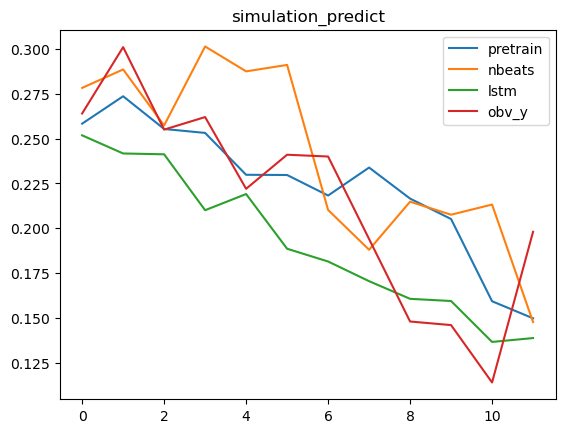

pretrain : 0.0013070277795167425 
nbeat : 0.0025215175176433427 
lstm  : 0.0014707896103734672


In [37]:
X_train1 = np.array(simul_X_train[7])
y_train1 = np.array(simul_y_train[7])
X_test1 = simul_low_X_test[3].reshape(1,-1)
y_test1 = simul_low_y_test[3].reshape(1,-1)


nbeat_lst=[]
nbeat_time = []
from sklearn.metrics import mean_squared_error
for  i in range(1):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = LSTM(128,return_sequences=True)(pretrained_output_reshaped )
#concatenated_output = Concatenate()([pretrained_output_reshaped, lstm_output])

# Dense layer
    dense_output = TimeDistributed(Dense(1))(lstm_output )

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model_combined.predict(X_test1)
    nbeat_mse=mean_squared_error(y_test1.flatten(),nbeat_pred.flatten()) 
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

    
nbeat_lst2=[]
nbeat_time2 = []
for i in range(1):
    K.clear_session()
    nonbeats= NBeatsKeras( backcast_length=24, forecast_length=12, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nonbeats.compile(loss='mse', optimizer=optimizer )
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=False)
    nonbeat_time1 = time.time()
    history3 = nonbeats.fit(X_train1,y_train1,validation_data=[X_test1,y_test1],
                             epochs=30, batch_size=2,
                             callbacks=[early_stop], verbose=0)
    nonbeat_time2 = time.time()
    no_total_training_time =nonbeat_time2- nonbeat_time1
    nbeat_pred2 = nonbeats.predict(X_test1)
    nbeat_mse2=mean_squared_error(y_test1.flatten(),nbeat_pred2.flatten())
    nbeat_lst2.append(nbeat_mse2)
    nbeat_time2.append(no_total_training_time)
    
    
    
lstm_lst=[]
lstm_time = []
for i in range(1):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(24,1),name='lstmd'))# (timestep, feature)
    modelnon0.add(Dense(12))# output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(X_train1,y_train1,validation_data=[X_test1,y_test1], epochs=30,
          batch_size=2, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    
    lstm_pred = modelnon0.predict(X_test1)
    lstm_mse=mean_squared_error(y_test1.flatten(),lstm_pred.flatten())
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

plt.plot(nbeat_pred.flatten(),label='pretrain')
plt.plot(nbeat_pred2.flatten(), label='nbeats')
plt.plot(lstm_pred.flatten(), label='lstm')
plt.plot(y_test1.flatten() ,label='obv_y')
plt.title("simulation_predict")
plt.legend()
plt.show()
print('pretrain :',np.mean(nbeat_lst),'\n'
      'nbeat :',np.mean(nbeat_lst2),'\n'
      'lstm  :',np.mean(lstm_lst))